# Diferenciacion automatica

Supongamos que necesitamos encontrar derivadas de la funcion $F(x)=(5x+1)^2$

Si descomponemos la funci\'on $F(x)=f(g(x))$, donde $f(x)=x^2$ y $g(x)=5x+1$ entonces podemos calcular la derivada de $\frac{\partial F(x)}{\partial x}$ como:

\begin{align}
\frac{\partial F(x)}{\partial x}=\frac{\partial f(g(x))}{\partial x} \times \frac{\partial g(x)}{\partial x}
\end{align}

In [2]:
from autograd import grad
from autograd.core import primitive
import autograd.numpy as np

def F(x):
    return (5*x+1)**2

grad_F = grad(F)

print ('F(X) : %.6f'%F(0.0))
print ('dF/dx : %.6f'%grad_F(0.0))

F(X) : 1.000000
dF/dx : 10.000000


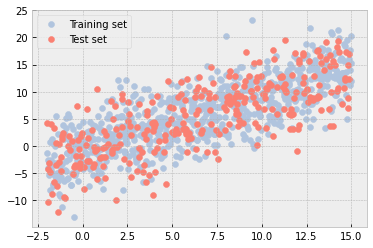

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import normal
plt.style.use('bmh')
%matplotlib inline

np.random.seed(3)

x = np.linspace(start = -2, stop=15, num=1000)
intercept, x_coef = -1, 1 
y = [x_coef*i + intercept for i in x]
y = [i+normal(0, 4) for i in y]

data = pd.DataFrame({'x': x, 'y': y})

# Split the data into training/testing sets
train, test = train_test_split(data, test_size=0.3)
X_train, X_test = train.x, test.x

# Split the targets into training/testing sets
y_train, y_test = train.y, test.y

plt.scatter(X_train, y_train, color='lightsteelblue', label = 'Training set')
plt.scatter(X_test, y_test, color='salmon', label = 'Test set')
plt.legend()

In [81]:
# root mean square
def rmse(y_true,y_hat):
  return np.sqrt(np.sum((y_true-y_hat)**2))

def net(X,par):
  return np.dot(X,par['weights'])+par['bias']


In [82]:
par={'weights':np.random.normal(0,.1),'bias':np.random.normal(0,.1)}

In [83]:
def training_loss(par):
  n_data=len(y_train)
  y_hat=net(X_train,par)
  return rmse(y_train,y_hat)*(1./n_data)

In [84]:
par

{'bias': -0.011069598345976555, 'weights': 0.03918941592544243}

In [85]:
training_loss(par)

0.3098049340049604

In [86]:
training_gradient_fun = grad(training_loss)

In [87]:
training_gradient_fun(par)

{'bias': array(-0.02494727), 'weights': array(-0.27039636)}

In [88]:
def train_net(par,iterations,eta=0.1):
    loss_history=[]
    eta=0.1
    for i in range(iterations):
      grad=training_gradient_fun(par)
      for var in par.keys():
        par[var] -= grad[var] * eta
      loss_history.append(training_loss(par))
      if i%(iterations/10)==0:
        print("Iteration : {0}, Trained loss: {1:0.4f}".format(i,training_loss(par)))
    return par,loss_history

In [ ]:
par,loss=train_net(par,80000,eta=0.0004)

Iteration : 0, Trained loss: 0.1474


In [93]:
par

{'bias': -0.2475079602097138, 'weights': 0.945894310699876}

In [94]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
res = model.fit(X_train.values.reshape((-1, 1)), y_train)
predictions = model.predict(X_test.values.reshape((-1, 1)))
print("intercept = ",res.intercept_,"solpe = ", res.coef_[0],)

intercept =  -0.9509429969262442 solpe =  1.015251015166013


# Redes Neuronales

Ahora en el contexto del aprendizaje automatico, queremos eoncontrar derivadas parciales de una funcion objetivo con respecto a los parametros del modelo. En el caso de problemas de clasificacion binaria multi-variable contamos con datos de entrada $\textbf X=(\mathbf x_1,\ldots,\mathbf x_n)$ y sus correspondientes etiquetas $\textbf y=(y_1,\ldots,y_n)$.

Para cada tupla $(x_i,y_i)$ podemos establecer la siguiente relacion lineal:

\begin{align}
\text{log}\left(\frac{p( C=1 \vert \mathbf x_i )}{p(C=0 \vert \mathbf x_i )} \right)&=w_0+\sum_{j=1}^{n} w_j\,x_{ij}\\
&=\mathbf w^T \mathbf x_i
\end{align}  

Al mismo tiempo , podemos obtener las probabilidades condicionales para cada clase:

\begin{align}
p(C=1\vert \textbf x_i)&= \phi(\mathbf w^T \mathbf x_i)=\frac{\text{exp}(\mathbf w^T \mathbf x_i)}{1+\text{exp}(\mathbf w^T \mathbf x_i)}
\end{align} 

Donde $\phi(\cdot)$ es la llamada función sigmoide.

La funcion sigmoide convierte cualquier entrada $\mathbf w^T \mathbf x_i \in [-\inf,\inf]$ hacia el intervalo $(0,1)$, por lo tanto podemos utilizar la funcion de verosimilitud de la distribucion de Bernoulli para comparar las probabilidad de clase con las etiquetas binarias:

\begin{align}
p(\textbf y, \textbf X,\mathbf w)= \prod_{i=1}^N (\phi(\mathbf w^T \mathbf x_i))^y_i \times (1-\phi(\mathbf w^T \mathbf x_i))^{1-y_i}
\end{align}

Ahora queremos obtener los parametros $\hat{\mathbf w}$ que maximicen la verosimilitud $p(\textbf y, \textbf X,\mathbf w)$. Dado que la funcion logaritmo es monotona en todo el dominio $[-\inf,\inf]$ utilizamos $\operatorname{log} p(\textbf y, \textbf X,\mathbf w)$ como funcion objetivo (log-loss):

\begin{align}
L(\mathbf w)=\sum_{i=1}^N (y_i \operatorname{log} \phi(\mathbf w^T \mathbf x_i)) + ({1-y_i}) \operatorname{log} (1-\phi(\mathbf w^T \mathbf x_i))
\end{align}

Ahora que tenemos definida una funcion objetivo, podemos evaluar iterativamente los pesos $w$ escogiendo la direccion de maximo crecimiento (gradiente).

\begin{align}
\mathbf w^{j+1}= \mathbf  w^j-\eta \frac{\partial L(\mathbf w)}{\partial \mathbf w}
\end{align}

Donde $\eta > 0$ es un factor de descuento o tasa de aprendizaje.

In [ ]:
from __future__ import absolute_import
from __future__ import print_function
from builtins import range
import autograd.numpy as np
from autograd import grad
from autograd.test_util import check_grads
import matplotlib.pyplot as plt

def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

def logistic_predictions(weights, inputs):
    # Outputs probability of a label being true according to logistic model.
    return sigmoid(np.dot(inputs, weights))

def training_loss(weights):
    # Training loss is the negative log-likelihood of the training labels.
    preds = logistic_predictions(weights, inputs)
    label_probabilities = np.log(preds) * targets + np.log((1 - preds)) * (1 - targets)
    return -np.sum(label_probabilities)

def train_net(weights,iterations,eta=0.1):
    loss_history=[]
    eta=0.1
    for i in range(iterations):
        weights -= training_gradient_fun(weights) * eta
        loss_history.append(training_loss(weights))
        if i%(iterations/10)==0:
            print("Iteration : {0}, Trained loss: {1}".format(i,training_loss(weights)))
    return weights,loss_history

# Build a function that returns gradients of training loss using autograd.
training_gradient_fun = grad(training_loss)

None
Iteration : 0, Trained loss: 2.283497754191519
Iteration : 100, Trained loss: 0.16583313868587354
Iteration : 200, Trained loss: 0.08498108937659068
Iteration : 300, Trained loss: 0.05693670361850756
Iteration : 400, Trained loss: 0.04275843168296287
Iteration : 500, Trained loss: 0.03421470813642524
Iteration : 600, Trained loss: 0.028508088444567432
Iteration : 700, Trained loss: 0.024428500857397714
Iteration : 800, Trained loss: 0.021367810994468505
Iteration : 900, Trained loss: 0.01898713850700267


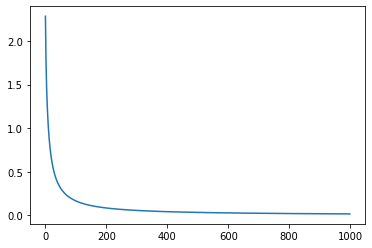

In [ ]:
# Build a toy dataset.
inputs = np.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = np.array([True, True, False, True])

# Check the gradients numerically, just to be safe.
weights = np.array([0.0, 0.0, 0.0])
print(check_grads(training_loss, modes=['rev'])(weights))
w_hat,loss=train_net(weights,1000)
plt.plot(loss)
plt.show()

None
Iteration : 0, Trained loss: 2.8778898579698207
Iteration : 10, Trained loss: 2.493684887493664
Iteration : 20, Trained loss: 2.014529246768627
Iteration : 30, Trained loss: 1.6648946343733293
Iteration : 40, Trained loss: 1.4181302835879974
Iteration : 50, Trained loss: 1.2788245524992412
Iteration : 60, Trained loss: 1.2055422750364944
Iteration : 70, Trained loss: 1.14903614892958
Iteration : 80, Trained loss: 1.100010659921956
Iteration : 90, Trained loss: 1.056727669353621
[ 2.69490392 -2.3583621 ]


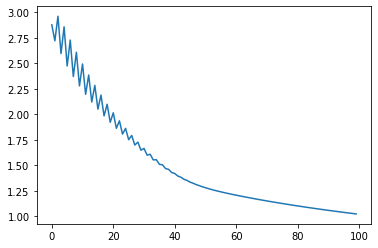

In [ ]:
inputs = np.array([[1, 1],
                   [4,2],
                   [4,5],
                   [5,5]])
targets = np.array([True, True, False, True])

# Check the gradients numerically, just to be safe.
weights = np.array([0.0, 0.0])
print(check_grads(training_loss, modes=['rev'])(weights))
w_hat,loss=train_net(weights,100,eta=1e-2)
print(w_hat)
plt.plot(loss)
plt.show()


Text(0.5, 1.0, 'Estimador de Maxima Verosimilitud $\\hat w=[2.69,-2.36]$')

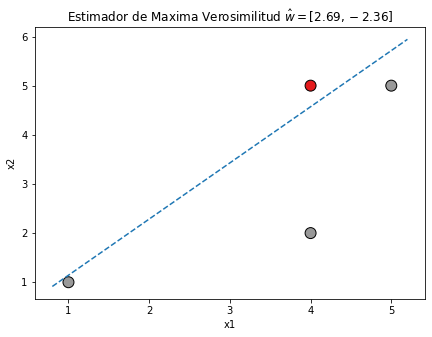

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets, cmap=plt.cm.Set1,edgecolor='k',s=120)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

def line(x0):
    return (-(x0 * w_hat[0]) ) / w_hat[1]

plt.plot([xmin, xmax], [line(xmin), line(xmax)],ls="--")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title(r'Estimador de Maxima Verosimilitud $\hat w=[{0:0.2f},{1:0.2f}]$'.format(w_hat[0],w_hat[1]))
#plt.savefig('prueba_clasificador.png')
#plt.close()

In [ ]:
print(w_hat)

[ 2.69490392 -2.3583621 ]


In [ ]:
logistic_predictions(w_hat,[3,4])>0.5

False

# Redes Neuronales Profundas

Una alternativa para superar el problema de la separacion lineal entre clases es utilizar multiples perceptrones ordenados en capas

La salida toma la siguiente forma:
\begin{align*}
f(\mathbf x) = \phi_0 \left(w_0+\sum_h w_{hk}\phi_h (\alpha_h+\sum_i w_{ih}x_i) \right)
\end{align*}

In [ ]:
from  sklearn import  datasets
iris=datasets.load_iris()
x=iris.data
y=iris.target


y=y[iris.target!=0]
x=x[iris.target!=0,:2]
idx = np.arange(x.shape[0])
np.random.seed(13)
np.random.shuffle(idx)
x = x[idx]
y = y[idx]

# standardize
mean = x.mean(axis=0)
std = x.std(axis=0)
x = (x - mean) / std

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.1)



None
Iteration : 0, Trained loss: 62.41566350937781
Iteration : 10, Trained loss: 87.87076294012196
Iteration : 20, Trained loss: 88.03869784625647
Iteration : 30, Trained loss: 88.03869804320504
Iteration : 40, Trained loss: 88.03869804320536
Iteration : 50, Trained loss: 88.03869804320534
Iteration : 60, Trained loss: 88.03869804320536
Iteration : 70, Trained loss: 88.03869804320534
Iteration : 80, Trained loss: 88.03869804320536
Iteration : 90, Trained loss: 88.03869804320534


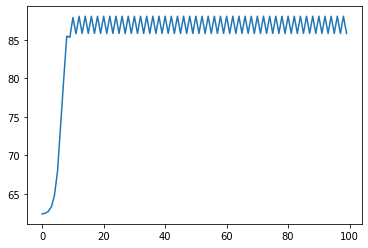

In [ ]:
inputs = x_train
targets = y_train==1

# Build a function that returns gradients of training loss using autograd.
weights = np.array([0.0, 0.0])
print(check_grads(training_loss, modes=['rev'])(weights))
w_hat,loss=train_net(weights,100,0.0001)

plt.plot(loss)
plt.show()

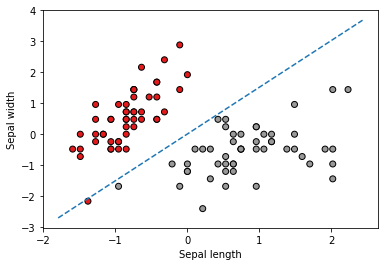

In [ ]:
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Set1,edgecolor='k')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

def line(x0):
    return (-(x0 * w_hat[0]) ) / w_hat[1]

plt.plot([xmin, xmax], [line(xmin), line(xmax)],ls="--")
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

In [ ]:
def deep_training_loss(weights):
    # Training loss is the negative log-likelihood of the training labels.
    input_layer = logistic_predictions(weights['input'], inputs).reshape(-1,1)
    hidden_layer = logistic_predictions(weights['hidden'], input_layer)
    output_layer = logistic_predictions(weights['output'],hidden_layer)
    label_probabilities = np.log(output_layer) * targets + np.log((1 - output_layer)) * (1 - targets)
    return -np.sum(label_probabilities)


# Build a function that returns gradients of training loss using autograd.
deep_training_gradient_fun = grad(deep_training_loss)

def train_deep_net(weights,iterations,eta=0.1):
    loss_history=[]
    for i in range(iterations):
        grad = deep_training_gradient_fun(weights)
        for w in weights.keys():
            weights[w] -= grad[w] * eta
        loss_history.append(deep_training_loss(weights))
        if i%(iterations/10)==0:
            print("Iteration : {0}, Trained loss: {1}".format(i,training_loss(weights)))
    return weights,loss_history

In [ ]:
num_hidden=10
weights = {'input':np.array([0.0, 0.0]),'hidden':np.zeros((1,num_hidden)),'output':np.zeros((num_hidden,1))}
print(check_grads(deep_training_loss, modes=['rev'])(weights))

w_hat,loss=train_deep_net(weights,10000,0.00001)

plt.plot(loss)
plt.show()

AssertionError: Derivative (VJP) check of vjp_deep_training_loss failed with arg ({'input': array([0., 0.]), 'hidden': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'output': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])}, array(-0.08847409)):
analytic: -298.89625903653064
numeric:  -300.7400404109716

In [ ]:
inputs.shape

(90, 2)

In [ ]:
deep_training_gradient_fun(weights)

{'hidden': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'input': array([0., 0.]),
 'output': array([[25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.]])}

In [ ]:
weights.keys()

dict_keys(['input', 'hidden', 'output'])